<a href="https://colab.research.google.com/github/farhan1503001/GANs/blob/main/Generative_Adversarial_Network_Using_Pytorch_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning with PyTorch : Build a Generative Adversarial Network 

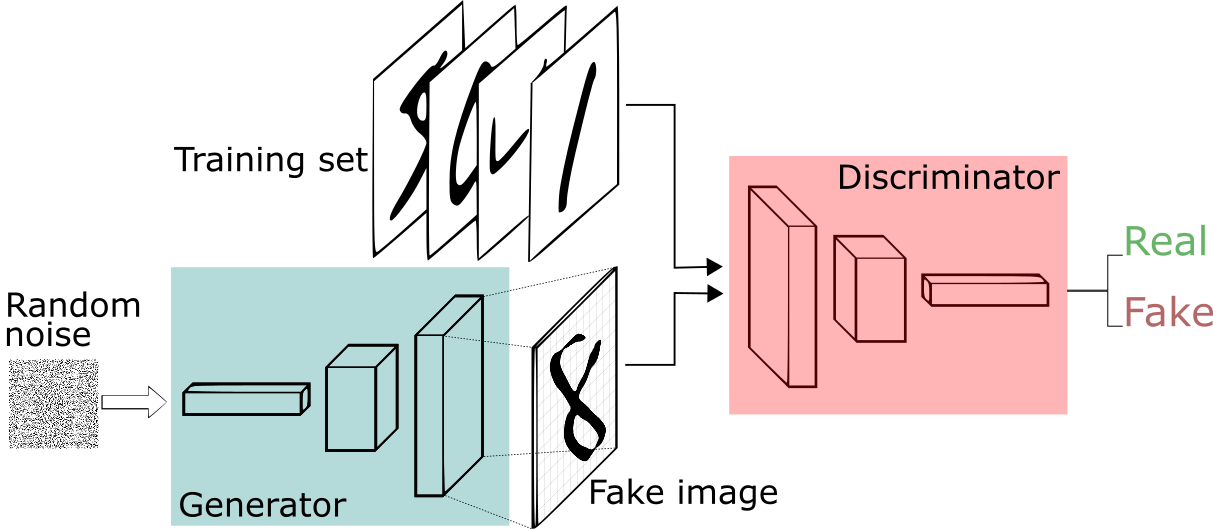

In [1]:
import torch 
torch.manual_seed(42)
import numpy as np 
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm

# Configurations

In [2]:
#Now defining all important constants and parameters
device='cuda'
batch_size=16
noise_dim=64 #will be used for our data
#Now setting optimizer parameters here we will use Adam optimizer
learning_rate=0.0002
beta_1=0.5
beta_2=0.99
#Training parameters
Epochs=20

# Load MNIST Dataset 

In [3]:
#Now we will be importing dataset and augmentations
from torchvision import datasets,transforms as Transformer

In [4]:
#Now training augmentation will be created
train_transformer=Transformer.Compose(
    [
      Transformer.RandomRotation((-20,+20)),
      Transformer.ToTensor() #it will convert our data from h,w,c to c,h,w format
    ]
)

In [5]:
#Now we will load the dataset
training_dataset=datasets.MNIST('MNIST/',download=True,transform=train_transformer)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



2
Image size is : torch.Size([1, 28, 28])


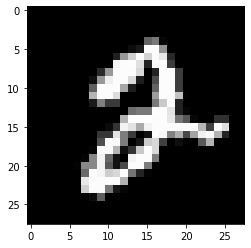

In [6]:
#Now we will try to visualize the image
image,label=training_dataset[5]
plt.imshow(image.squeeze(),cmap='gray')
print(label)
print("Image size is :",image.shape)

In [7]:
#Now checking the dataset size
print("The total number of image present in this dataset: ",len(training_dataset))
print("Each image is of size: ",image.shape)

The total number of image present in this dataset:  60000
Each image is of size:  torch.Size([1, 28, 28])


# Load Dataset Into Batches 

In [8]:
#Now we will import dataloaders for making batch loading possible
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid

In [9]:
#Now batch load the data
train_loader=DataLoader(training_dataset,batch_size=batch_size,shuffle=True)

In [10]:
print("Finding out Total Number of Batches in Loader: ",len(train_loader))

Finding out Total Number of Batches in Loader:  3750


In [11]:
#Now visualizing each batch_shape
dataiter=iter(train_loader)
image,_=dataiter.next()
print("Shape of a batch image: ",image.shape)

Shape of a batch image:  torch.Size([16, 1, 28, 28])


In [12]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

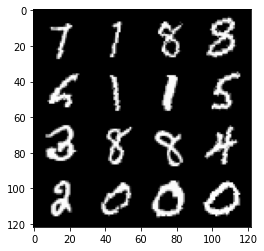

In [13]:
#Visualizing tensor images
show_tensor_images(image,num_images=16)

# Create Discriminator Network 

In [14]:
#In case if torch summary is not installed 
! pip install torchsummary

In [15]:
import torch.nn as nn

from torchsummary import summary

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

In [16]:
from torch.nn.modules.activation import LeakyReLU
#creating a common dicriminator block
def disciriminator_block(in_channels,out_channels,kernel_size,stride):
  return nn.Sequential(
     nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=kernel_size,stride=stride),
     nn.BatchNorm2d(num_features=out_channels),
     nn.LeakyReLU(negative_slope=0.2)
  )

In [17]:
#Now creating our discreminator model
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()

    self.conv_block_1=disciriminator_block(1,16,(3,3),2)
    self.conv_block_2=disciriminator_block(16,32,(5,5),2)
    self.conv_block_3=disciriminator_block(32,64,(5,5),2)
    #now flatten layer
    self.flatten=nn.Flatten()
    self.linear=nn.Linear(64,1)

  def forward(self,image):
    x1=self.conv_block_1(image)
    x2=self.conv_block_2(x1)
    x3=self.conv_block_3(x2)

    x4=self.flatten(x3)
    x5=self.linear(x4)

    return x5

In [18]:
D=Discriminator()
D.to(device)

summary(D,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network 

In [ ]:
'''

Network : Generator 

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) 
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

In [19]:
z_dim=64
def generator_block(in_channels,out_channels,kernel_size,stride,final_layer=False):
  if final_layer==True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride),
        nn.Tanh()
    )
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [20]:
#Now creating generator model class
class Generator(nn.Module):
  def __init__(self,noise_dim) -> None:
      super(Generator,self).__init__()

      self.noise_dim=noise_dim
      self.transpose_block1=generator_block(noise_dim,256,(3,3),2)
      self.transpose_block2=generator_block(256,128,(4,4),1)
      self.transpose_block3=generator_block(128,64,(3,3),2)
      #final_block
      self.final_block=generator_block(64,1,(4,4),2,final_layer=True)

  def forward(self,noise_vector):
    #Now first we have to change input vector dimension
    #from (bs,noise_dim)__> It will become (bs,noise_dim,1,1)
    x=noise_vector.view(-1,self.noise_dim,1,1)

    x1=self.transpose_block1(x)
    x2=self.transpose_block2(x1)
    x3=self.transpose_block3(x2)

    x4=self.final_block(x3)
    return x4

In [21]:
#Now calling the generator model
G=Generator(noise_dim=64)
G.to(device)
summary(G,input_size=(1,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [22]:
# Replace Random initialized weights to Normal weights  

def weights_init(m):  
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [23]:
#Now we will be using normal weights instead of random ones so have 
#to just apply to each of the models
G.apply(weights_init)
D.apply(weights_init)

Discriminator(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

# Create Loss Function and Load Optimizer

In [24]:
#Now writing real and fake loss functions for our discriminator and generator
def real_loss(disc_pred):
  #Just defining our loss function
  loss_criteria=nn.BCEWithLogitsLoss()
  #gaining loss value
  ground_truth=torch.ones_like(disc_pred)
  loss=loss_criteria(disc_pred,ground_truth)
  return loss
#Now writing function for fake loss
def fake_loss(disc_pred):
  loss_criterion=nn.BCEWithLogitsLoss()
  ground_truth=torch.zeros_like(disc_pred)
  loss=loss_criterion(disc_pred,ground_truth)
  return loss

In [25]:
#Now defining our optimizer
Discriminator_optim=torch.optim.Adam(D.parameters(),lr=learning_rate,betas=(beta_1,beta_2))
Generator_optim=torch.optim.Adam(G.parameters(),lr=learning_rate,betas=(beta_1,beta_2))

# Training Loop 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


For Epoch 0_-->G_loss=0.8365708473682404--->D_loss=0.5908271533807119


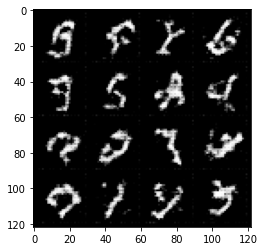

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


For Epoch 1_-->G_loss=0.9782010064204534--->D_loss=0.5532015706857045


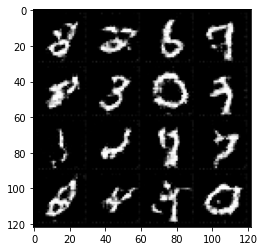

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


For Epoch 2_-->G_loss=0.8964962134520212--->D_loss=0.6162936926285426


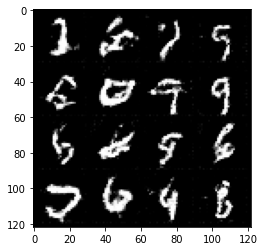

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


For Epoch 3_-->G_loss=0.8428823349634806--->D_loss=0.6424645722707113


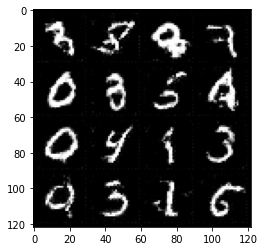

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


For Epoch 4_-->G_loss=0.8255996124903361--->D_loss=0.6484067198514938


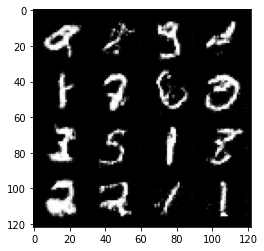

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


For Epoch 5_-->G_loss=0.8200512005488078--->D_loss=0.6512714565912883


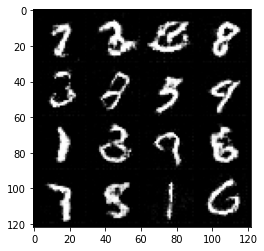

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


For Epoch 6_-->G_loss=0.8178059027671813--->D_loss=0.6516028987725576


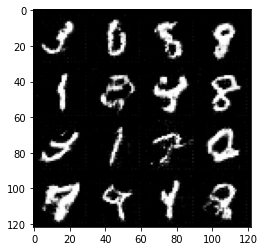

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


For Epoch 7_-->G_loss=0.8156965250492096--->D_loss=0.6525910662333171


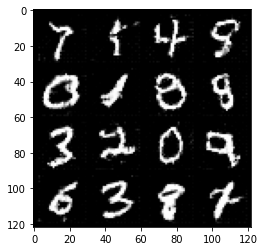

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


For Epoch 8_-->G_loss=0.8218287499109904--->D_loss=0.6506374941190084


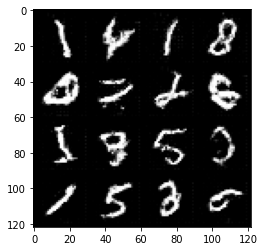

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


For Epoch 9_-->G_loss=0.8193192667802175--->D_loss=0.6509781764666239


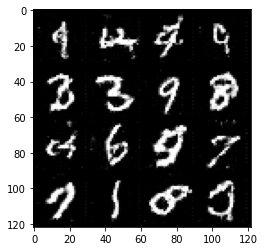

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


For Epoch 10_-->G_loss=0.8260878440539042--->D_loss=0.6503125394662221


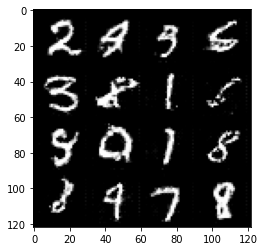

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


For Epoch 11_-->G_loss=0.8235025608857472--->D_loss=0.6487959443092346


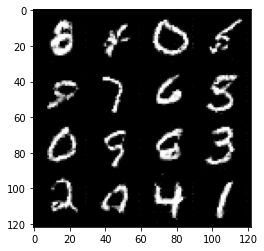

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


For Epoch 12_-->G_loss=0.8302056044419607--->D_loss=0.6484047319730123


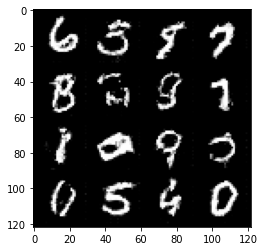

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


For Epoch 13_-->G_loss=0.8317229531606039--->D_loss=0.6441202862342199


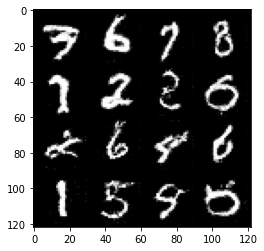

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


For Epoch 14_-->G_loss=0.8413727599620819--->D_loss=0.644893903764089


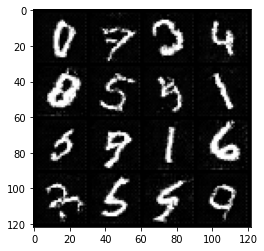

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


For Epoch 15_-->G_loss=0.8516010437647502--->D_loss=0.638700877737999


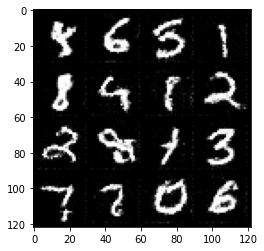

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


For Epoch 16_-->G_loss=0.857724229224523--->D_loss=0.6366650216817856


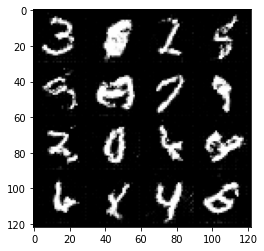

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


For Epoch 17_-->G_loss=0.8641023506959279--->D_loss=0.6334278639793396


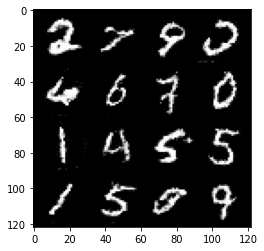

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


For Epoch 18_-->G_loss=0.8741629826068879--->D_loss=0.6309644825140636


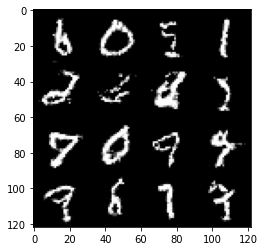

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


For Epoch 19_-->G_loss=0.8829660537083943--->D_loss=0.6258435780604681


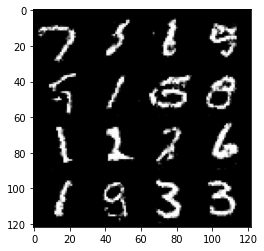

In [26]:
for i in range(Epochs):
  total_d_loss=0.0
  total_g_loss=0.0
  for img,label in train_loader:
    #sending image to device
    img=img.to(device)
    #creating noise vector
    noise=torch.randn(batch_size,noise_dim,device=device)
    #Now finding loss and weight update for discriminator
    Discriminator_optim.zero_grad()
    fake_img=G(noise)
    pred_img=D(fake_img)
    D_fake_loss=fake_loss(pred_img)
    #for real loss
    pred_img=D(img)#using real image
    D_real_loss=real_loss(pred_img)
    #finding d loss
    d_loss=(D_fake_loss+D_real_loss)/2.0
    #add d_loss to it's total
    total_d_loss+=d_loss.item()
    d_loss.backward()
    Discriminator_optim.step()


    #Now for generative loss
    Generator_optim.zero_grad()
    noise=torch.randn(batch_size,noise_dim,device=device)
    #generate a fake image
    fake_img=G(noise)
    pred_img=D(fake_img)
    g_loss=real_loss(pred_img)
    #Now add to total loss
    total_g_loss+=g_loss.item()

    g_loss.backward()
    Generator_optim.step()
  avg_d_loss=total_d_loss/len(train_loader)
  avg_g_loss=total_g_loss/len(train_loader)

  print(f"For Epoch {i}_-->G_loss={avg_g_loss}--->D_loss={avg_d_loss}")
  show_tensor_images(fake_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


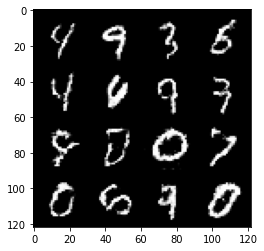

In [27]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)